In [11]:
import pandas as pd
import yfinance as yf 
import datetime as dt
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#Tickers, weight of stocks, Start to end Date
assets= ['msft', 'tsla', 'k']
benchmarks = ['spy','iwm','dia']

weight_of_stocks = [1, 1, 1]

start = '2019-09-18'
end = '2024-09-01'

In [3]:
benchmarks = [asset.upper() for asset in benchmarks]
assets = [asset.upper() for asset in assets]

tickers = assets + benchmarks

#un-hashtag the code below, it is in hash for testing purposes
#data = yf.download(tickers, start=start, end=end )['Adj Close']
data = yf.download(tickers, start=start)['Adj Close']

num_stock = len(assets)
total_weight = sum(weight_of_stocks)
percent_weight = [w / total_weight for w in weight_of_stocks]

[*********************100%***********************]  6 of 6 completed


In [4]:
daily_returns = data.pct_change().dropna().mean()
#{num_trading_days insid of annualized returns is rounded 
# down one to accomodate function} also check if you have to use 252/63
annual_returns = data.pct_change(252).dropna().mean()
annual_std = data.pct_change(252).dropna().std()
annual_vol = data.pct_change(63).dropna().std() * np.sqrt(252/63)

In [5]:
def calc_beta(asset_returns, benchmark_returns):
    X = sm.add_constant(benchmark_returns)
    model = sm.OLS(asset_returns, X).fit()
    return model.params[1]


In [6]:
weekly_high= data.rolling(window=52).max()
weekly_low= data.rolling(window=52).min()
weekly_drawdown= (weekly_low-weekly_high)/weekly_high
avg_weekly_drawdown = weekly_drawdown.rolling(window=52).mean()
max_weekly_drawdown = weekly_drawdown.rolling(window=52).min()

avg_weekly_drawdown=avg_weekly_drawdown[assets].mean()
max_weekly_drawdown=max_weekly_drawdown[assets].max()

In [7]:
portfolio_df = pd.DataFrame({
    'Ticker': assets,
    'Portfolio Weight': percent_weight,
    #'Annualized Std': annual_std[assets],
    #'Annualized Returns': annual_returns[assets],
    'Annual Vol.': annual_vol[assets],
    #'Portfolio Return': annual_returns[assets]* percent_weight,
    #'Portfolion Std': annual_std[assets]* percent_weight,
    'Beta against SPY': [calc_beta(data[ticker].pct_change().dropna(), data['SPY'].pct_change().dropna()) for ticker in assets],
    'Beta against IWM': [calc_beta(data[ticker].pct_change().dropna(), data['IWM'].pct_change().dropna()) for ticker in assets],
    'Beta against DIA': [calc_beta(data[ticker].pct_change().dropna(), data['DIA'].pct_change().dropna()) for ticker in assets],
    'Avg Weekly Drawdown': avg_weekly_drawdown,
    'Max Weekly Drawdown': max_weekly_drawdown
})

portfolio_df.reset_index(drop=True, inplace=True)
portfolio_df.index = portfolio_df.index + 1
portfolio_df

/var/folders/qs/c8khbpsj6mz0700tf80pw_hr0000gn/T/ipykernel_2380/3582574454.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return model.params[1]
/var/folders/qs/c8khbpsj6mz0700tf80pw_hr0000gn/T/ipykernel_2380/3582574454.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return model.params[1]
/var/folders/qs/c8khbpsj6mz0700tf80pw_hr0000gn/T/ipykernel_2380/3582574454.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return mo

,Ticker,Portfolio Weight,Annual Vol.,Beta against SPY,Beta against IWM,Beta against DIA,Avg Weekly Drawdown,Max Weekly Drawdown
1,MSFT,0.333333,0.224636,1.190433,0.654464,1.049840,-0.151279,-0.097303
2,TSLA,0.333333,0.905434,1.594205,1.165100,1.282270,-0.358067,-0.206867
3,K,0.333333,0.214932,0.296220,0.142470,0.363281,-0.117177,-0.074190


In [8]:
etfs = ['SPY', 'QQQ', 'IWM']
historical_data = yf.download(etfs, start='2019-09-18', end='2024-09-01')
returns = historical_data['Adj Close'].pct_change().dropna()
correlation = returns.corr()
covariance = returns.cov()
#tracking_error = (returns - returns['not sure']).abs().mean()
sharpe_ratio = returns.mean() / returns.std()
#annualized_volatility = returns.std() * pd.np.sqrt(252)
volatility_spread = (returns.std() - returns['SPY'].std()).abs()

table = pd.DataFrame({
    'ETF': etfs,
    'Correlation': correlation.loc['SPY', etfs],
    'Covariance': covariance.loc['SPY', etfs],
    #'Tracking Error': tracking_error[etfs],
    'Sharpe Ratio': sharpe_ratio[etfs],
    #'Annualized Volatility': annualized_volatility[etfs],
    'Volatility Spread': volatility_spread[etfs],
})

print(table)

[*********************100%***********************]  3 of 3 completed

        ETF  Correlation  Covariance  Sharpe Ratio  Volatility Spread
Ticker                                                               
SPY     SPY     1.000000    0.000174      0.049565           0.000000
QQQ     QQQ     0.930401    0.000197      0.054925           0.002865
IWM     IWM     0.867514    0.000195      0.027689           0.003875


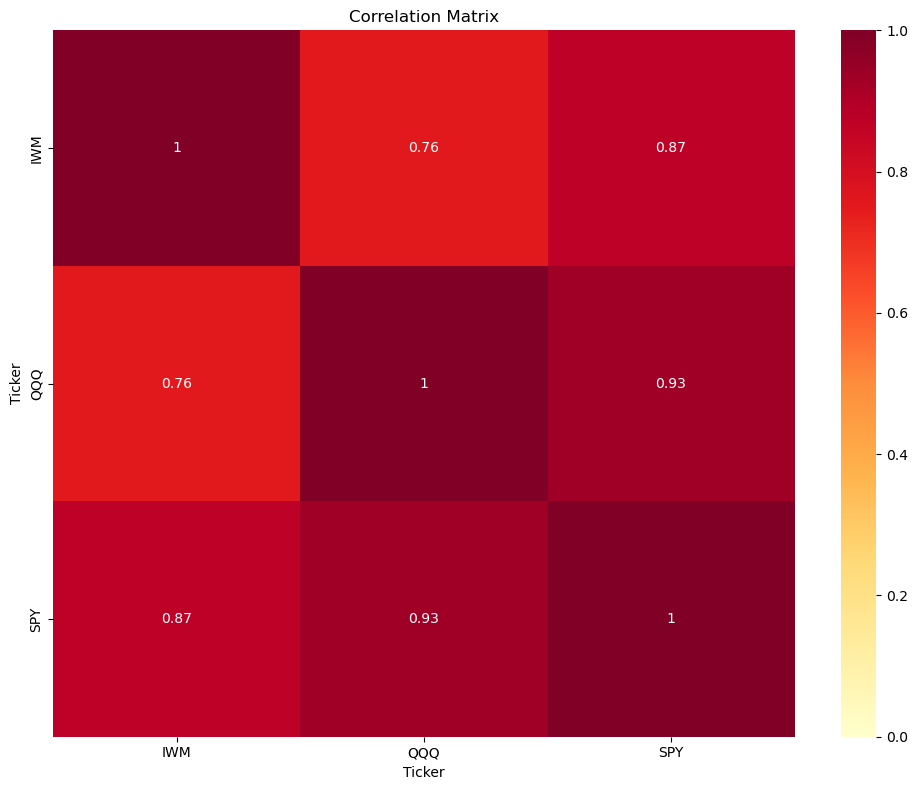

In [12]:
plt.figure(figsize=(10, 8))
sns.heatmap(correlation, annot=True, cmap='YlOrRd', vmin=0, vmax=1)
plt.title('Correlation Matrix')
plt.tight_layout()

plt.show()